In [2]:
import pandas as pd
import os
import nibabel as nib
import matplotlib.pyplot as plt
import zipfile

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Build `Dataset` class that enable reading the custom data we

+ CN = 0
+ SCZ = 1

In [10]:
import os
import nibabel as nib
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []

        # Iterate over each fold
        for fold in os.listdir(self.root_dir):
            fold_dir = os.path.join(self.root_dir, fold)

            # Check if it's a directory
            if os.path.isdir(fold_dir):
              a = os.listdir(fold_dir)
              folder_name_in_fold_i = a[0]
              fold_dir = os.path.join(fold_dir, folder_name_in_fold_i)
              # Iterate over CN and schiz folders
              for category in ['CN', 'schiz']:
                  category_dir = os.path.join(fold_dir, category)
                  if category == "CN":
                    Category_num = 0
                  else:
                    Category_num = 1

                  # Check if the category folder exists
                  if os.path.isdir(category_dir):
                      # Iterate over image files
                      for file in os.listdir(category_dir):
                          file_path = os.path.join(category_dir, file)
                          # Append sample tuple (image path, fold, category) to the list

                          ############## Get the source of the image
                          # Find the index of the 7th and 8th appearance of "_"
                          count = 0
                          seventh_index = -1
                          for i, char in enumerate(file):
                              if char == "_":
                                  count += 1
                                  if count == 7:
                                      seventh_index = i
                                  if count == 8:
                                      eighth_index = i
                                      break
                          #extract the tex between the 7th and 8th apperance of "_"
                          source = file[seventh_index + 1:eighth_index]
                          samples.append((file_path, fold, source, Category_num))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, fold, source, category = self.samples[idx]

        # Load the NIfTI image
        img = nib.load(file_path)

        # Get the image data array
        img_data = img.get_fdata()

        # Convert to PyTorch tensor
        img_tensor = torch.tensor(img_data, dtype=torch.float32)

        return img_tensor, fold, source, category

    def display_image(self, idx, show_image = True):
        file_path, fold, source, category = self.samples[idx]
        if category == 0:
          category = "CN"
        else:
          category = "schiz"
        # Load the NIfTI image
        img = nib.load(file_path)

        # Get the image data array
        img_data = img.get_fdata()

        # Display one of the slices (e.g., middle slice along the first dimension)
        slice_num = img_data.shape[0] // 2  # Get the middle slice
        slice_data = img_data[slice_num, :, :]  # Extract the slice data

        # Plot the slice
        if show_image:
          plt.imshow(slice_data, cmap='gray')
          plt.axis('off')  # Turn off axis labels
          plt.title(f'MRI Image\n Class: {category}, Source: {source}')
          #plt.subtitle(f"Class: {category}, Source: {source}")
          plt.show()
        return slice_data


## Create the data set

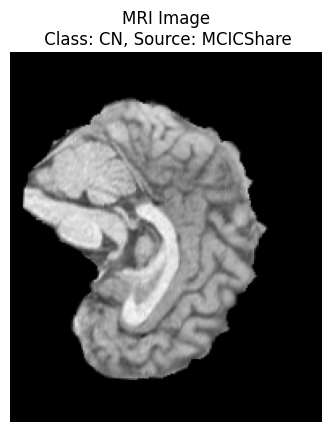

In [11]:
# Define the root directory where your data is located
root_dir = "/content/drive/MyDrive/BME Project/Data/SCZ classification"

# Create an instance of the dataset
dataset = CustomDataset(root_dir)

# Accessing an individual sample
# sample_idx = 1
# img_tensor, fold, category = dataset[sample_idx]

sample_image_array = dataset.display_image(101)

## Split the data to train-test

In [6]:
from sklearn.model_selection import train_test_split

def split_dataset(dataset, limit = 100, test_size=0.2, random_state=770, verbose = True):
    # Extracting the features and labels from the dataset
    x = []
    y_class = []  # Class labels
    y_source = []  # Source labels

    if limit > len(dataset):
      number_of_images_to_evaluate = len(dataset)
      print("Number of images to evaluate is:", len(dataset))
    else:
      number_of_images_to_evaluate = limit
      print(f"Number of images to evalute is: {limit}, note that there is a total of {len(dataset)} images")

    for i in range(number_of_images_to_evaluate):
        img_tensor, _, source, category = dataset[i]
        x.append(img_tensor)
        y_class.append(category)
        y_source.append(source)

    # Splitting the dataset into train and test sets
    x_train, x_test, y_class_train, y_class_test, y_source_train, y_source_test = \
        train_test_split(x, y_class, y_source, test_size=test_size, random_state=random_state)

    if verbose:
      print("")
      print("Number of data samples we evaluate:", number_of_images_to_evaluate)
      print("Number of train samples:", len(y_class_train))
      print("Number of test samples:", len(y_class_test))

    return x_train, y_class_train, y_source_train, x_test, y_class_test, y_source_test


In [7]:
x_train, y_class_train, y_source_train, x_test, y_class_test, y_source_test = \
split_dataset(dataset = dataset, limit = 100, test_size=0.2, random_state=770, verbose = True)

Number of images to evalute is: 100, note that there is a total of 1878 images
Number of data samples we evaluate: 100
Number of train samples: 80
Number of test samples: 20


In [9]:
y_class_test


['CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN',
 'CN']

In [5]:
print("Number of data samples:", len(dataset))


Number of data samples: 1878


In [84]:
dataset

[('/content/drive/MyDrive/BME Project/Data/SCZ classification/fold1/MNI152_affine_WB_iso1mm/CN/MNI152_affine_WB_MNI152_affine_WH_iso1mm_NUSDAST_sub-CC1960_ses-20021030_acq-mprage_run-03__WB.nii.gz',
  'fold1',
  'CN'),
 ('/content/drive/MyDrive/BME Project/Data/SCZ classification/fold1/MNI152_affine_WB_iso1mm/CN/MNI152_affine_WB_MNI152_affine_WH_iso1mm_NUSDAST_sub-CC5562_ses-20040104_acq-mprage_run-01__WB.nii.gz',
  'fold1',
  'CN'),
 ('/content/drive/MyDrive/BME Project/Data/SCZ classification/fold1/MNI152_affine_WB_iso1mm/CN/MNI152_affine_WB_MNI152_affine_WH_iso1mm_NUSDAST_sub-CC1960_ses-20021030_acq-mprage_run-02__WB.nii.gz',
  'fold1',
  'CN'),
 ('/content/drive/MyDrive/BME Project/Data/SCZ classification/fold1/MNI152_affine_WB_iso1mm/CN/MNI152_affine_WB_MNI152_affine_WH_iso1mm_NUSDAST_sub-CC7335_ses-20030805_acq-mprage_run-04__WB.nii.gz',
  'fold1',
  'CN'),
 ('/content/drive/MyDrive/BME Project/Data/SCZ classification/fold1/MNI152_affine_WB_iso1mm/CN/MNI152_affine_WB_MNI152_affin

In [ ]:
dataset.display_image(0)

In [65]:
### Extract an image:
sample_idx = 1
img_tensor, fold, category = dataset[sample_idx]

## use the display image method:
dataset.display_image(0)



In [75]:
image_list = []
for i in range(10):
  image_list.append(dataset.display_image(i, show_image = False))

In [ ]:
images_list =

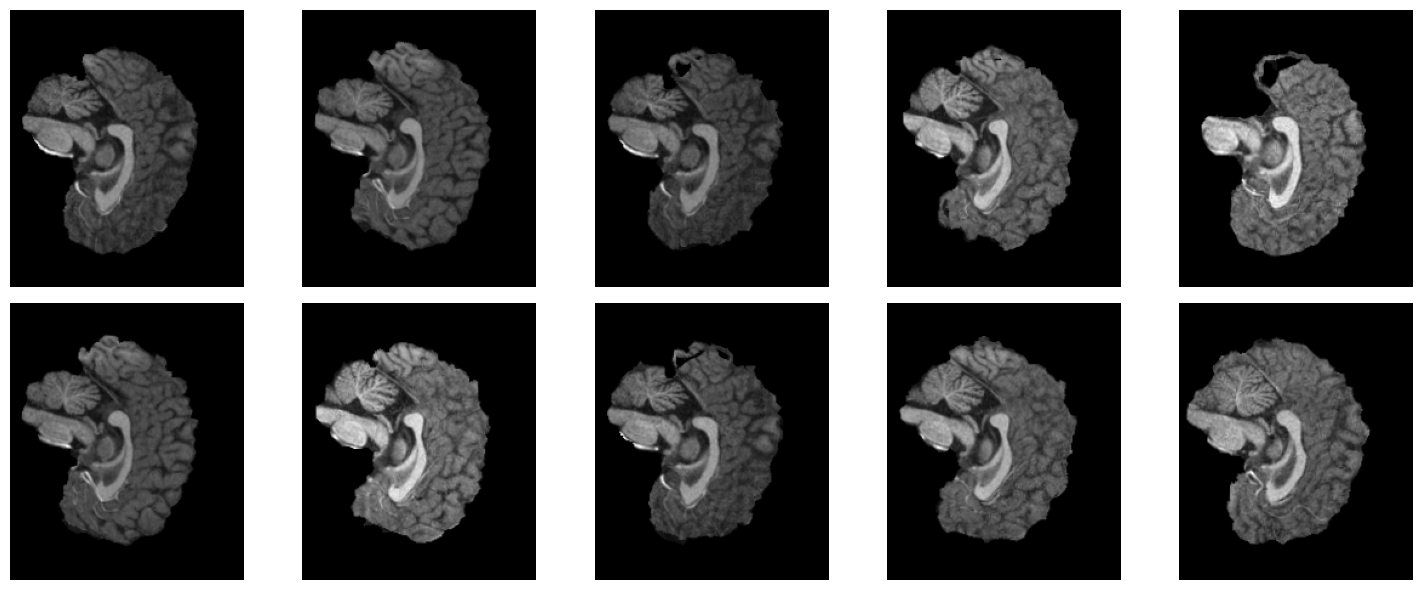

In [76]:
import matplotlib.pyplot as plt

# Assuming `images` is a list of 10 images (PyTorch tensors or numpy arrays)
# images = [image1, image2, ..., image10]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        axes[i, j].imshow(image_list[idx], cmap='gray')  # Assuming grayscale images
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [64]:
file_path, fold, category = dataset.samples[0]


img = nib.load(file_path)
img_data = img.get_fdata()
torch.tensor(img_data, dtype=torch.float32)


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

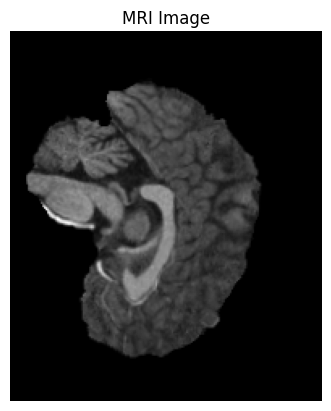

In [62]:
# Get the image data array
#img_data = img.get_fdata()

# Display one of the slices (e.g., middle slice along the first dimension)
slice_num = img_data.shape[0] // 2  # Get the middle slice
slice_data = img_data[slice_num, :, :]  # Extract the slice data

# Plot the slice
plt.imshow(slice_data, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.title('MRI Image')
plt.show()


In [52]:
#Accessing an individual sample
sample_idx = 1
img_tensor, fold, category = dataset[sample_idx]

In [48]:
# Iterate over each fold
for fold in os.listdir(root_dir):
    fold_dir = os.path.join(root_dir, fold)
    print(fold_dir)
    # Check if it's a directory
    if os.path.isdir(fold_dir):
      a = os.listdir(fold_dir)
      folder_name_in_fold_i = a[0]
      fold_dir = os.path.join(fold_dir, folder_name_in_fold_i)
      # Iterate over CN and schiz folders
      for category in ['CN', 'schiz']:
        category_dir = os.path.join(fold_dir, category)
        if os.path.isdir(category_dir):
          print(category)
    break

/content/drive/MyDrive/BME Project/Data/SCZ classification/fold1
CN
schiz


'MNI152_affine_WB_iso1mm'

In [ ]:
# Iterate over each fold
for fold in os.listdir(root_dir):
    fold_dir = os.path.join(root_dir, fold)

    # Check if it's a directory
    if os.path.isdir(fold_dir):
        # Iterate over CN and schiz folders
        for category in ['CN', 'schiz']:
            category_dir = os.path.join(fold_dir, category)
            # Check if the category folder exists
            if os.path.isdir(category_dir):
                # Iterate over image files
                for file in os.listdir(category_dir):
                    file_path = os.path.join(category_dir, file)
                    # Append sample tuple (image path, fold, category) to the list
                    samples.append((file_path, fold, category))

In [37]:
folder_path = "/content/drive/MyDrive/BME Project/Data/SCZ classification"
folder_contents = os.listdir(folder_path)
# Print the list of contents
print("Contents of the folder:")
for item in folder_contents:
    print(item)



Contents of the folder:
fold1
fold2
SchizConnect_Patient_info
fold3
fold4
fold5
fold6
fold7
fold9
fold8
fold10


In [30]:
folder_path = "/content/drive/MyDrive/BME Project/Data/SCZ classification/fold1/MNI152_affine_WB_iso1mm/CN"
folder_contents = os.listdir(folder_path)
# Print the list of contents
print("Contents of the folder:")
for item in folder_contents:
    print(item)


In [31]:
item

'MNI152_affine_WB_MNI152_affine_WH_iso1mm_NMorphCH_sub-CH8004a_ses-20110701_acq-mprage_run-01__WB.nii.gz'

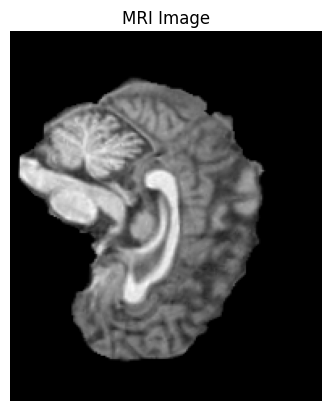

In [32]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the NIfTI image
image_path = folder_path + '/' + item
img = nib.load(image_path)

# Get the image data array
img_data = img.get_fdata()

# Display one of the slices (e.g., middle slice along the first dimension)
slice_num = img_data.shape[0] // 2  # Get the middle slice
slice_data = img_data[slice_num, :, :]  # Extract the slice data

# Plot the slice
plt.imshow(slice_data, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.title('MRI Image')
plt.show()


In [ ]:
#########################################################################

In [17]:
folder_path = "/content/drive/MyDrive/BME Project/Data/Orginal_prof_data/fold1"
folder_contents = os.listdir(folder_path)
# Print the list of contents
print("Contents of the folder:")
for item in folder_contents:
    print(item)



Contents of the folder:
MNI152_affine_WB_iso1mm-20240320T205615Z-001.zip


In [18]:
import zipfile
# Specify the path to the zip file within the shared folder
zip_file_path = folder_path + '/' + 'MNI152_affine_WB_iso1mm-20240320T205615Z-001.zip'


# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/BME Project/Data/Orignial_data_extracted')


<zipfile.ZipFile [closed]>

In [2]:
##https://huggingface.co/subh71/medical
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("subh71/medical")
model = AutoModelForImageClassification.from_pretrained("subh71/medical")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]